In [1]:
import time

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from simple_ml import generate_dataset, plot_functions, train
from simple_ml.model import ShallowNetwork

pd.set_option('max_colwidth', 500)
sns.set_theme()

%load_ext autoreload
%autoreload 2

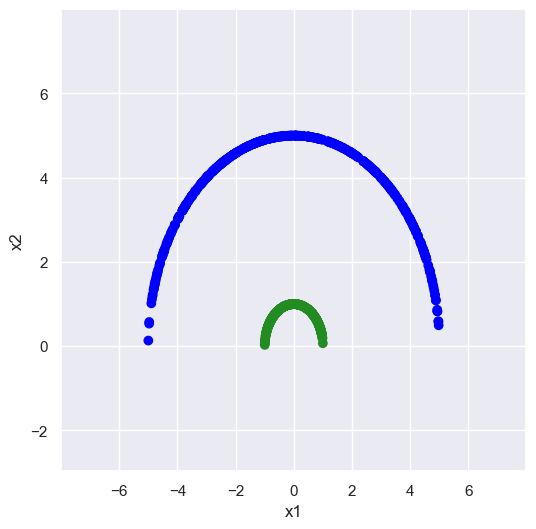

In [2]:
NUM_DATA_POINTS_PER_CLASS = 500

# There are other dataset options including lines and a full-circle.
df = generate_dataset.generate_semi_circle_dataset(inner_radius=1, outer_radius=5, num_data_points_per_class=NUM_DATA_POINTS_PER_CLASS)

plot_functions.create_dataset_plot(df, ndim=2)

### Perform many, many training runs

In [8]:
# Oh man!! I wasn't using a ModuleList to wrap the series of HiddenUnit objects within the broader ShallowNetwork object. The optimizer did not recognize 
# parameters of those HiddenUnit's so they weren't trained at all! That explains why I was finding so MANY unique solutions.

# The performance as a function of the number of processes used was surprisingly variable. These are the results I observed for an n=3 points per class semi-circle dataset and total 100 training runs.
# Ah, I suspect the variance of the number-of-steps-to-converge is playing a role, even though I'm taking 100 samples. Though, I only suspected it after observing it, hah!

# 1 process: 2265 seconds.
# 3 processes: 683 seconds.
# 4 processes: 574 seconds.
# 6 processes: 393 seconds.
# 9 processes: 876 seconds.

# I then began recording the average number of steps to reach convergence along with the time elapsed.
# 1 process:   2612 seconds, and on average 97,000  steps. Seconds / 1k steps: 27. (Note: this was using the serial framework.)
# 1 process:   2003 seconds, and on average 77,000  steps. Seconds / 1k steps: 26. (Note: this was using the multi-process framework with n=1).
# 2 processes: 912  seconds, and on average 60,000  steps. Seconds / 1k steps: 15.
# 3 processes: 1703 seconds, and on average 121,000 steps. Seconds / 1k steps: 14.
# 4 processes: 346  seconds, and on average 35,000  steps. Seconds / 1k steps: 10.
# 5 processes: 1597 seconds, and on average 95,000  steps. Seconds / 1k steps: 17.
# 6 processes: 586  seconds, and on average 47,000  steps. Seconds / 1k steps: 12.
# 7 processes: 701  seconds, and on average 60,000  steps. Seconds / 1k steps: 12.

# I put a decent amount of effort into selecting the num_steps_to_improve_min_amount hyper-parameter.
# I first ran the training process with this hyper-parameter. Once training halted, I re-ran the training process 
# starting from the learned model rather than a freshly initialized model, and with a paramteter value 100 times 
# larger. If the loss achieved on the second run is 5e-4 (5 times the min-improvement of 1e-4) lower, then I considered 
# the initial selection of this hyper-parameter value to be too low. I then repeated this 25 times with different 
# model-initializations each time. If any of the 25 trials failed, then I'd increase the hyper-parameters' value.

# For example, I first trained with 1,000 steps as the number of steps to see a minimal improvement, then 
# waited for training to halt, then re-ran the training process with 100,000 steps as the number of 
# steps to see minimal improvement. If the loss after re-running was better beyond some tiny threshold,
# then, I'd have chosen a parameter larger than 1,000 and gone through the whole validation process again.

# With a value of 5,000 steps and 50 data-points per semi-circle, 22 runs passed the trial and 1 failed the trial, since the model improved from 
# a loss of 0.001 to 0.0001. I think that's close enough.

import simple_ml.multiprocess_train_many as multiprocess_train_many

NUM_STEPS_TO_IMPROVE_MIN_AMOUNT = 5_000
MIN_LOSS_IMPROVEMENT = 1e-4
NUM_TRAINING_RUNS = 10_000


start_time = time.time()

result_df = multiprocess_train_many.multiprocess_train(
    num_processes=4, 
    training_df=df,
    num_training_runs=NUM_TRAINING_RUNS,
    min_loss_improvement=MIN_LOSS_IMPROVEMENT, 
    num_steps_to_improve_min_amount=NUM_STEPS_TO_IMPROVE_MIN_AMOUNT,
)

print(f"Time elapsed: {time.time() - start_time:.0f}s. Average number of training-steps (rounded to the nearest thousand): {int(result_df['num_training_steps'].mean().round(-3)):,}.")
result_df.to_pickle(f"artifacts/{NUM_TRAINING_RUNS}_training_runs_on_semicircle_dataset_n-{NUM_DATA_POINTS_PER_CLASS}.pkl")

100%|███████████████| 10000/10000 [4:28:04<00:00,  1.61s/it]


Time elapsed: 16090s. Average number of training-steps (rounded to the nearest thousand): 24,000.


### Analyze the results

##### How many unique valleys were found?

In [14]:
performance_df['best_loss'].round(3).value_counts().sort_index()

best_loss
0.045    1766
0.049    3553
0.084    3318
0.693    1363
Name: count, dtype: int64

In [16]:
# performance_df = pd.read_pickle("optimization_results_for_100_model_initializations.pkl")
performance_df = result_df

print(f"Number of unique best-loss scores obtained to 5 degrees of precision: {performance_df['best_loss'].round(5).nunique():,}.")
print(f"Number of unique best-loss scores obtained to 4 degrees of precision: {performance_df['best_loss'].round(4).nunique():,}.")
print(f"Number of unique best-loss scores obtained to 3 degrees of precision: {performance_df['best_loss'].round(3).nunique():,}.")
print(f"Number of unique best-loss scores obtained to 2 degrees of precision: {performance_df['best_loss'].round(2).nunique():,}.")
print(f"Number of unique best-loss scores obtained to 1 degree of precision: {performance_df['best_loss'].round(1).nunique():,}.")

performance_df['best_loss'] = performance_df['best_loss'].round(4)

Number of unique best-loss scores obtained to 8 degrees of precision: 8.
Number of unique best-loss scores obtained to 4 degrees of precision: 8.
Number of unique best-loss scores obtained to 3 degrees of precision: 4.
Number of unique best-loss scores obtained to 2 degrees of precision: 3.
Number of unique best-loss scores obtained to 1 degree of precision: 3.


##### Are any models nearly identical?

This approach only checks if all parameters are nearly equal. It does not account for ReLU's non-negative homogeneity.

In [ ]:
# No matches found to 4, 3 nor 2 degrees of precision.
matching_indices = []
for outer_idx, model in tqdm.tqdm(enumerate(display_df[non_unique_loss_indices]['model'])):
    for inner_idx, other_model in enumerate(display_df[non_unique_loss_indices]['model']):
        
        if outer_idx <= inner_idx:
            continue
        if model.nearly_equals(other_model, precision=1):
            # print(f"Found match!! Models at indices {outer_idx} and {inner_idx} are nearly equal.")
            
            if inner_idx not in matching_indices:
                matching_indices.append(inner_idx)
            if outer_idx not in matching_indices:
                matching_indices.append(outer_idx)

matching_indices = pd.Series(matching_indices)

In [ ]:
non_unique_loss_indices = performance_df['loss'].duplicated(keep=False)
performance_df[non_unique_loss_indices].sort_values('loss')

##### Visualize the results

In [48]:
performance_df['log_2_num_training_steps'] = performance_df['num_training_steps'].apply(np.log2)
_ = sns.scatterplot(data=performance_df, x='log_2_num_training_steps', y='loss')

ValueError: Could not interpret value `loss` for `y`. An entry with this name does not appear in `data`.

In [ ]:
bins = np.arange(0, 70, 0.1)
_ = sns.histplot(data=performance_df, x='loss', bins=bins)

### Compare CPU and GPU

In [40]:
import copy

NUM_STEPS_TO_IMPROVE_MIN_AMOUNT = 5_000
MIN_LOSS_IMPROVEMENT = 1e-4
NUM_TRAINING_RUNS = 10_000

loss_fn = torch.nn.BCELoss(reduction='none')
original_model = ShallowNetwork(num_hidden_units=1)


gpu_model = copy.deepcopy(original_model)
gpu_optimizer = torch.optim.Adam(gpu_model.parameters())

start_time = time.time()
learned_model, best_loss, num_training_steps = train.train(
    gpu_model, loss_fn, gpu_optimizer, 
    training_df=df, 
    min_improvement=MIN_LOSS_IMPROVEMENT, 
    num_steps_to_improve_min_amount=NUM_STEPS_TO_IMPROVE_MIN_AMOUNT, 
    device=torch.device('mps')
)
print(f"Time elapsed on GPU: {time.time() - start_time:.0f}s. Loss: {best_loss.item():.5f}. Number of training-steps: {num_training_steps:,}.")


cpu_model = copy.deepcopy(original_model)
cpu_optimizer = torch.optim.Adam(cpu_model.parameters())

start_time = time.time()
learned_model, best_loss, num_training_steps = train.train(
    cpu_model, loss_fn, cpu_optimizer, 
    training_df=df,
    min_improvement=MIN_LOSS_IMPROVEMENT, 
    num_steps_to_improve_min_amount=NUM_STEPS_TO_IMPROVE_MIN_AMOUNT, 
    device=torch.device('cpu')
)
print(f"Time elapsed on CPU: {time.time() - start_time:.0f}s. Loss: {best_loss.item():.8f}. Number of training-steps: {num_training_steps:,}.")

Time elapsed on GPU: 47s. Loss: 0.00010. Number of training-steps: 28,034.
Time elapsed on CPU: 6s. Loss: 0.00010. Number of training-steps: 28,028.


In [ ]:
print(f"original_model: {original_model}.")
print(f"learned gpu model: {gpu_model}.")
print(f"learned cpu model: {cpu_model}.")